## Generating Images from Text
In this project, we will combine two models (CLIP and tamed-transformers) to generate images from text.

Here we are going to study architrectiure like CLIP. Connectting text and images. CLIP stands for **Contrastive Language–Image Pre-training**. It builds on a large body of work on zero-shot transfer, natural language supervision, and multimodal learning.

CLIP (Contrastive Language-Image Pre-training) is a neural network model developed by OpenAI that can learn to associate images and text. CLIP is trained on a massive dataset of images and text pairs, and it can be used to perform a variety of tasks, such as:

* Image captioning: Given an image, CLIP can generate a caption that describes the image. <br/>
    
* Text-to-image retrieval: Given a text description, CLIP can retrieve images that match the description. <br/>
    
* Image-to-text retrieval: Given an image, CLIP can retrieve text descriptions that match the image. <br/>
   
* Zero-shot learning: CLIP can be used to perform tasks that it has never been explicitly trained on, such as identifying objects in images or translating languages.

CLIP is a powerful tool that can be used to bridge the gap between language and vision. It has the potential to revolutionize a variety of applications, such as image search, machine translation, and virtual assistants.

The CLIP paper by OpenAI provides a detailed overview of the model, including its architecture, training methodology, and evaluation results. The paper also discusses the potential applications of CLIP and the challenges that still need to be addressed.

Here are some of the key findings from the CLIP paper:

* CLIP is able to learn to associate images and text with a high degree of accuracy.<br/>
* CLIP can be used to perform a variety of tasks, such as image captioning, text-to-image retrieval, and image-to-text retrieval. <br/>
* CLIP is able to generalize to new tasks that it has never been explicitly trained on. <br/>
* CLIP is a powerful tool that can be used to bridge the gap between language and vision. <br/>

The CLIP paper is a significant contribution to the field of artificial intelligence. It provides a new approach to the problem of image understanding and opens up the possibility of new applications in a variety of domains.

In [1]:
!git clone https://github.com/openai/CLIP.git
# Learning transferable visual models from natural language supervision

!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 247 (delta 0), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (247/247), 8.93 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 34.94 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
# load some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 635.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 6.1 MB/s eta 0:00:00
Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00


In [3]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml # mark up langauge
from omegaconf import OmegaConf

from CLIP import clip

# import warning
# warnings.futurewargnings("ignore")

In [14]:
# helper functions
def show_from_tensor(tensor):
  img = tensor.clone() # we are going to clone tensor so that we get it on seprate variable and seprate part of memory
  img = img.mul(255).byte() # multiply by 255 because range is b/w 0 & 1 and cast it as a byte
  img = img.cpu().numpy().transpose(1,2,0)  # width x height x channel

  plt.figure(figsize=(10,7))
  plt.axis("off")
  plt.imshow(img)
  plt.show()

def norm_data(data): # to normalize the data
  return (data.clip(-1,1)+1)/2 # range b/w 0 and 1

Now let's define the parameters.

In [5]:
## Parameters
learning_rate = 0.5
batch_size = 1 # beacuse we want to work with just a single image
wd = 0.1 # "wd" means weight_decay is a regularizer parameter to improve the generalization capabilities of the architecture
noise_factor = 0.1  # we will create some crops of image to resize those crops. And noise factor will imrpove optimization process.

total_iter = 100   # we get the encodings of the texts and image through CLIP,
                        # And then calculate the loss using Cosine Similarity mathematical function applied to result of those encodings.

im_shape = [225,400,3] # height, width, channel
size1, size2, channels = im_shape

Now we will use CLIP model.  

In [6]:
# clip.load model will return two things, but we need only 1st thing
clipmodel,_ =  clip.load("ViT-B/32",jit=False)
clipmodel.eval()  # Beacuse clipmodel is already trained (pre-trained), we just want to evaluate
print(clip.available_models())

print("Clip model visual input resolution: ",clipmodel.visual.input_resolution)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 221MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


Above the CLIP library has downloaded its pretrained model. So, we don't need to train CLIP, and we can proceed to use it in infrence, eval mode to encode texts and images directly.

<b><u>Note:</u></b>: Please note above that Clip model visual input resolution is 224. This is very important. It means that when we encode images in CLIP, we  need to set them at 224 pixels.

Now intialization of taming transfomer.

In [7]:
# Taming transformer instantiation
%cd  /content/taming-transformers/

/content/taming-transformers


In [8]:
## Making some directories
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
#vqgan is internal architecture used in this type of transformer
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

--2023-08-07 07:47:23--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/9f125a67-2837-42c9-b197-b85ff5643276/last.ckpt [following]
--2023-08-07 07:47:23--  https://heibox.uni-heidelberg.de/seafhttp/files/9f125a67-2837-42c9-b197-b85ff5643276/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  8.34MB/s    in 1m 46s  

2023-08-07 07:49:09 (8.81 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980092370]

--2023-08-07 07:49:0

In above, if we execute this, we begin to download from Heidelberg, the pre-trained vqgan model architecture, both the checkpoint, the last train, the model and also the configuration information.     

Now we have got the checkpoints we can proceed to instantiate that taming transformer VQGAN architecture.

<b><u>Very Important</u></b>: Before running the cell below, make the following cahenges:
* Go to taming folder on left side of colab
* Go to taming > data > utils.py
* In that utils.py file comment out from torch._six import string_classes using putting hash tag before it like #from torch._six import string_classes
* Add a line above string_classes = str
* Save the utils.py file

In [10]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


8.19kB [00:00, 127kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


Note above the 16 resolution above. We have to modify according to this later.

Now we will declare our latent space and values that we are going to optimize.

In [29]:
### Declare the values that we are going to optimize
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters,self).__init__()
    self.data = .5*torch.randn(batch_size,256,size1//16,size2//16).cuda() # 1 x 256 x 14 x 25 (225/16), (400/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{"params":[params.data],"lr":learning_rate}],weight_decay=wd)
  return params, optimizer

Next task is to encode the text prompts through CLIP.

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


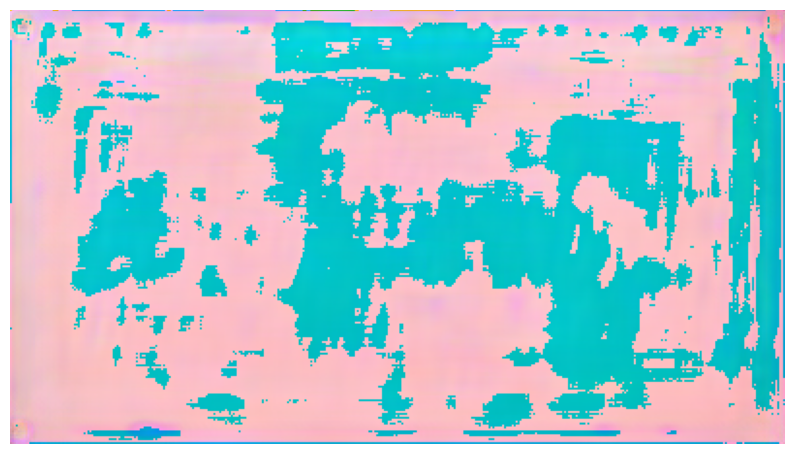

In [40]:
### Encoidngs prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t = clip.tokenize(text).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include,exclude,extras): # e.g. picture of eplephant dancing in forest, but with no color, and it is a rainy season
                                             # here incude = picture of eplephant dancing in forest, exclude = no color
                                             # extras = rainy season
  include_enc = []
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc = encodeText(exclude)  if exclude != "" else 0 # because exclude and extras are optional
  extras_enc = encodeText(extras) if extras != "" else 0

  return include_enc, exclude_enc, extras_enc

# We are also creating the crops of the image.
# The augments are first applied to the single image produced by the generator. ANd then from the output, different crops are created
augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30,(.2,.2),fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = generator(Params()).cpu() # 1 x 3 x 224 x 400 and we wanted to obtain [225 x 400]
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])


This is sample image of shape 1,3,224,400.

Next we are going to create crops. And in croips we send multiple images not just a single one. SO, we atre going to send 30 in our case.

In [49]:
### Create crops

def create_crops(img,num_crops=30):
  p = size1//2 # for padding
  img = torch.nn.functional.pad(img,(p,p,p,p),mode="constant",value=0) # 1 x 3 x 448 x 624 (adding 112 x 2 on all sides to 224 x 400)
  img = augTransform(img) # randomHorizontalFlip and RandomAffine is applied

  crop_set = []
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.0,0.5,()).clip(0.2,1.5) * size1)
    gap2 = int(torch.normal(1.0,0.5,()).clip(0.2,1.5) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop = img[:,:,offsetx:offsetx+gap2, offsety:offsety+gap2]

    crop = torch.nn.functional.interpolate(crop,(224,224),mode="bilinear",align_corners=True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set,0) # we are concatenating because we are sending them all of them at once
                                    # 30 x 3 x 224 x 224 (30 crops toegther)
  img_crops = img_crops + noise_factor*torch.randn_like(img_crops,requires_grad=False) # adding some noise to it

  return img_crops

Now we need a function that display the image during training.

In [50]:
def showme(Params,show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() #  1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen,num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

Now we are going to create a function that is going to allow us to actually do the optimization to gradually change the value of those parameters so that image gradually moves in a direction that matches the conext of the text prompt.

In [54]:
## Optimization process
def optimize_result(Params,prompt):
  alpha = 1 ## the imporatnce of include encodings
  beta = 0.5 ## the importance of exclude encodings

  ## image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc =  clipmodel.encode_image(out) # 30 x 512

  ## text encoding w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc: 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1,keepdim=True) # 1x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc,image_enc,-1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc,image_enc,-1) #30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params,optimizer,prompt):
  loss = optimize_result(Params,prompt).mean() # because we are going to loss value of each of these and then we are ccalculating avg
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

Now we define the function for the training loop.

In [55]:
## training loop

def training_loop(params,optimizer,show_crop=False):
  res_img = []
  res_z = [] # we are going to save different images that we generate and also different set of parameters for interpolation etc

  for prompt in include_enc:
    iteration = 0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25  (225/16, 400/16)

    for iteration in range(total_iter): # we have set to 100 in beginning of program
      loss = optimize(Params,optimizer,prompt)

      if iteration>0 and iteration%(total_iter-1) == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params())  # 1 x 256 x 14 x 25
        print("loss: ",loss.item(), "\iteration",iteration)

      iteration += 1
    return res_img, res_z

Now we are going to train the model.

Augmented cropped example


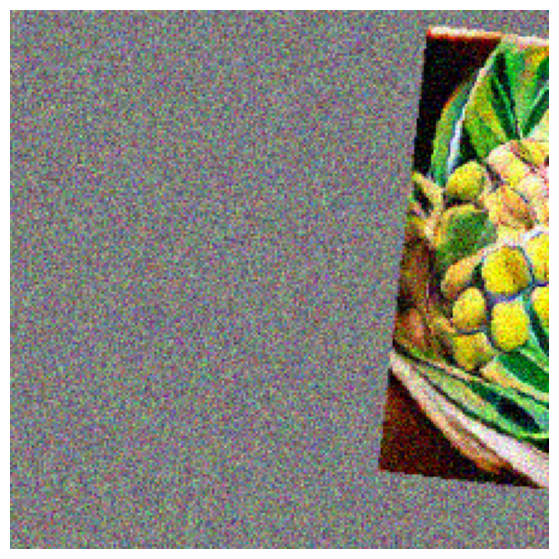

Generation


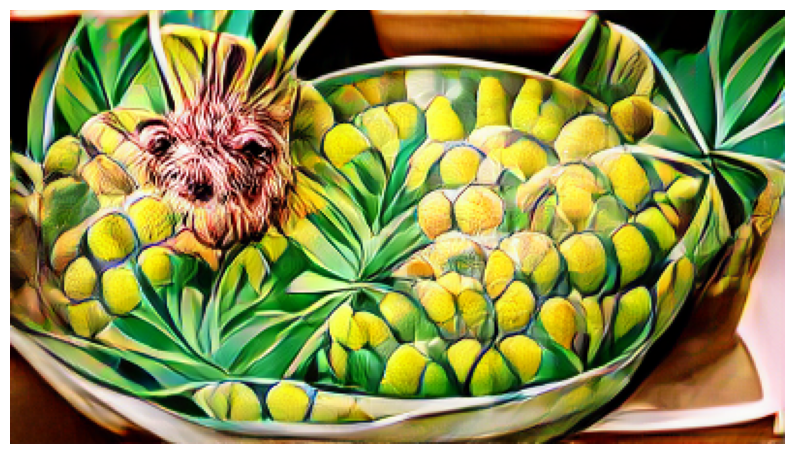

loss:  -0.23291015625 \iteration 109


In [56]:
torch.cuda.empty_cache()
#include=['sketch of a lady', 'sketch of a man on a horse']
include=['A painting of a pineapple in a bowl']
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


Augmented cropped example


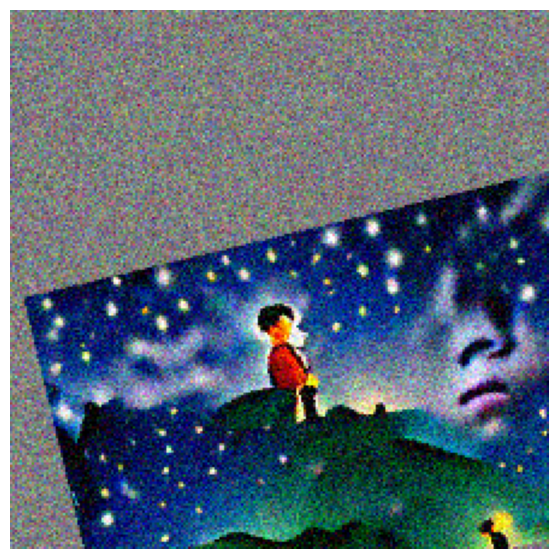

Generation


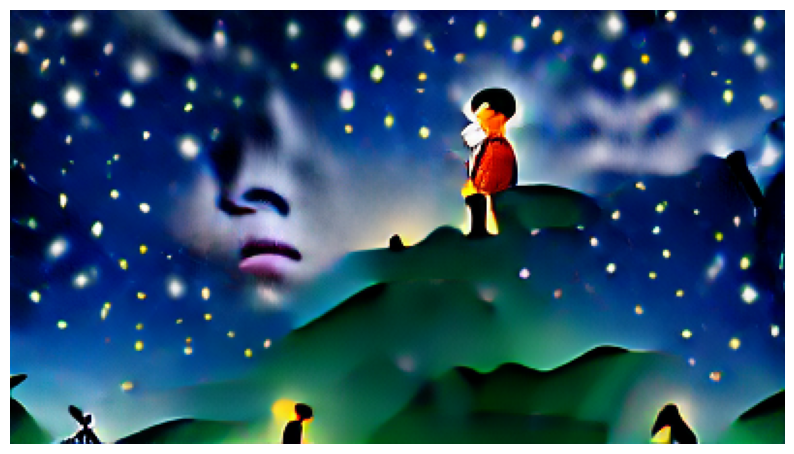

loss:  -0.2144775390625 \iteration 109


In [58]:
torch.cuda.empty_cache()
include=['a boy at top of mountain, looking at the stars']
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


Next we are going to do the interpolation between the latent space.

In [59]:
def interpolate(res_z_list, duration_list):
  gen_img_list=[] 
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)): #going to set of each of latent parameters & of duration
    num_steps = int(duration*fps) # telling that one of the image should last this second
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)  Next latent point. Modular "%" sign will help 
                                                                                         # you to go from 1,2,3  then back to 1

    for step in range(num_steps): # now we will create step
      alpha = math.sin(1.5*step/num_steps)**6  # linear interpolation
      z_new = alpha * z2 + (1-alpha) * z1 # new point in the latent space

      new_gen=norm_data(generator(z_new).cpu())[0] ## 3 x 224 x 400
      new_img=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations=[5,5,5,5,5,5]
interp_result_img_list = interpolate(res_z, durations)

In [60]:
## create a video
out_video_path=f"../video.mp4" # we are still in the folder of taming-transformer. So we need to get out of that folder
writer = imageio.get_writer(out_video_path, fps=25)  # to write video file 
for pil_img in interp_result_img_list: 
  img = np.array(pil_img, dtype=np.uint8) # we are going to convert numpy array to unassigned integer of bits 
  writer.append_data(img)  # we need to append the data to the file
 
writer.close() # close the file 

In [61]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)